In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import deeplake
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
# Загрузка данных
ds = deeplake.load('hub://activeloop/not-mnist-small')

2023-09-27 02:58:33.003842: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 02:58:33.214478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 02:58:33.217031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 02:58:34.608517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gea/.local/lib/python3.8/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.7.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/not-mnist-small



\

hub://activeloop/not-mnist-small loaded successfully.



In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


In [4]:
labels = np.array(ds['labels'])

In [5]:
# Преобразование данных в numpy массивы
images = np.array(ds['images'])
labels = np.array(ds['labels'])

# Разбиение данных на тренировочный и тестовый наборы
notmnist_train, notmnist_test, _, _ = train_test_split(images, labels, test_size=0.2, random_state=42)

In [15]:
labels.shape, images.shape

((18724, 1), (18724, 28, 28))

In [28]:
#Обучение энкодера и декодера на Not MNIST


notmnist_train, notmnist_test, _, _ = train_test_split(images, labels, test_size=0.2, random_state=42)
# Нормализация данных
notmnist_train = notmnist_train.astype('float32') / 255.
notmnist_test = notmnist_test.astype('float32') / 255.

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1)) 

# Энкодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что fashion_train и fashion_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
notmnist_train = notmnist_train.reshape(-1, 28, 28, 1)
notmnist_test = notmnist_test.reshape(-1, 28, 28, 1)

autoencoder.fit(notmnist_train, notmnist_train,
                epochs=10,
                batch_size=128,
                validation_data=(notmnist_test, notmnist_test))


Epoch 1/10
118/118 [==============================] - 54s 453ms/step - loss: 0.3563 - val_loss: 0.1722
Epoch 2/10
118/118 [==============================] - 54s 456ms/step - loss: 0.1599 - val_loss: 0.1558
Epoch 3/10
118/118 [==============================] - 53s 452ms/step - loss: 0.1485 - val_loss: 0.1446
Epoch 4/10
118/118 [==============================] - 53s 452ms/step - loss: 0.1440 - val_loss: 0.1418
Epoch 5/10
118/118 [==============================] - 53s 452ms/step - loss: 0.1413 - val_loss: 0.1408
Epoch 6/10
118/118 [==============================] - 53s 450ms/step - loss: 0.1395 - val_loss: 0.1370
Epoch 7/10
118/118 [==============================] - 53s 451ms/step - loss: 0.1368 - val_loss: 0.1359
Epoch 8/10
118/118 [==============================] - 54s 454ms/step - loss: 0.1364 - val_loss: 0.1346
Epoch 9/10
118/118 [==============================] - 53s 450ms/step - loss: 0.1348 - val_loss: 0.1344
Epoch 10/10
118/118 [==============================] - 54s 458ms/step - l

In [23]:
notmnist_train.shape

(14979, 28, 28, 1)

118/118 [==============================] - 2s 20ms/step


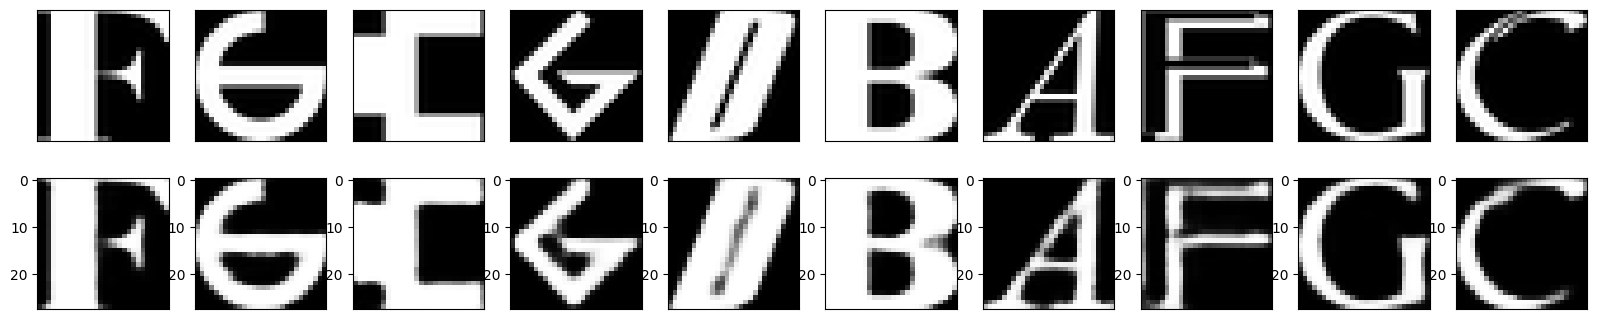

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(notmnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(notmnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
#     ax.get_y


In [30]:
#Тренировка и прогнозирование Fassion MNIST


# Загрузка и предобработка данных
(fashion_train, fashion_train_labels), (fashion_test, fashion_test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Нормализация данных
fashion_train = fashion_train.astype('float32') / 255.
fashion_test = fashion_test.astype('float32') / 255.

# Создание модели для Fashion MNIST на основе весов кодировщика
encoder = Model(input_img, encoded)
for layer in encoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(fashion_train, fashion_train_labels, epochs=20, batch_size=256, validation_data=(fashion_test, fashion_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test)

Epoch 1/20
235/235 [==============================] - 17s 69ms/step - loss: 0.6589 - accuracy: 0.7779 - val_loss: 0.4848 - val_accuracy: 0.8295
Epoch 2/20
235/235 [==============================] - 16s 69ms/step - loss: 0.4342 - accuracy: 0.8451 - val_loss: 0.4308 - val_accuracy: 0.8437
Epoch 3/20
235/235 [==============================] - 16s 69ms/step - loss: 0.3905 - accuracy: 0.8612 - val_loss: 0.4001 - val_accuracy: 0.8568
Epoch 4/20
235/235 [==============================] - 16s 69ms/step - loss: 0.3666 - accuracy: 0.8697 - val_loss: 0.3847 - val_accuracy: 0.8634
Epoch 5/20
235/235 [==============================] - 16s 68ms/step - loss: 0.3527 - accuracy: 0.8739 - val_loss: 0.3704 - val_accuracy: 0.8694
Epoch 6/20
235/235 [==============================] - 16s 68ms/step - loss: 0.3398 - accuracy: 0.8787 - val_loss: 0.3633 - val_accuracy: 0.8717
Epoch 7/20
235/235 [==============================] - 16s 68ms/step - loss: 0.3300 - accuracy: 0.8819 - val_loss: 0.3568 - val_accuracy:

In [31]:
#Тренировка и прогнозирование MNIST

(mnist_train, mnist_train_labels), (mnist_test, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.

# Создание модели для Fashion MNIST на основе весов кодировщика
encoder = Model(input_img, encoded)
for layer in encoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

mnist_model = Model(input_img, predictions)
mnist_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mnist_model.fit(mnist_train, mnist_train_labels, epochs=20, batch_size=256, validation_data=(mnist_test, mnist_test_labels))

# Предсказание
predictions = mnist_model.predict(fashion_test)

Epoch 1/20
235/235 [==============================] - 16s 68ms/step - loss: 0.5609 - accuracy: 0.8601 - val_loss: 0.2689 - val_accuracy: 0.9230
Epoch 2/20
235/235 [==============================] - 16s 68ms/step - loss: 0.2362 - accuracy: 0.9316 - val_loss: 0.1982 - val_accuracy: 0.9425
Epoch 3/20
235/235 [==============================] - 16s 70ms/step - loss: 0.1928 - accuracy: 0.9436 - val_loss: 0.1713 - val_accuracy: 0.9488
Epoch 4/20
235/235 [==============================] - 16s 69ms/step - loss: 0.1657 - accuracy: 0.9510 - val_loss: 0.1561 - val_accuracy: 0.9529
Epoch 5/20
235/235 [==============================] - 16s 68ms/step - loss: 0.1514 - accuracy: 0.9549 - val_loss: 0.1374 - val_accuracy: 0.9597
Epoch 6/20
235/235 [==============================] - 16s 68ms/step - loss: 0.1357 - accuracy: 0.9595 - val_loss: 0.1409 - val_accuracy: 0.9564
Epoch 7/20
235/235 [==============================] - 16s 69ms/step - loss: 0.1265 - accuracy: 0.9624 - val_loss: 0.1212 - val_accuracy:

In [5]:
# Загрузка и предобработка данных
(fashion_train, fashion_train_labels), (fashion_test, fashion_test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Нормализация данных
fashion_train = fashion_train.astype('float32') / 255.
fashion_test = fashion_test.astype('float32') / 255.

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # Fashion MNIST - черно-белые изображения

# Энкодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что fashion_train и fashion_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
fashion_train = fashion_train.reshape(-1, 28, 28, 1)
fashion_test = fashion_test.reshape(-1, 28, 28, 1)

autoencoder.fit(fashion_train, fashion_train,
                epochs=20,
                batch_size=256,
                validation_data=(fashion_test, fashion_test))


Epoch 1/20
235/235 [==============================] - 264s 1s/step - loss: 0.3430 - val_loss: 0.2920
Epoch 2/20
235/235 [==============================] - 259s 1s/step - loss: 0.2804 - val_loss: 0.2866
Epoch 3/20
235/235 [==============================] - 257s 1s/step - loss: 0.2760 - val_loss: 0.2763
Epoch 4/20
235/235 [==============================] - 259s 1s/step - loss: 0.2729 - val_loss: 0.2762
Epoch 5/20
235/235 [==============================] - 256s 1s/step - loss: 0.2707 - val_loss: 0.2717
Epoch 6/20
235/235 [==============================] - 267s 1s/step - loss: 0.2693 - val_loss: 0.2713
Epoch 7/20
235/235 [==============================] - 254s 1s/step - loss: 0.2682 - val_loss: 0.2696
Epoch 8/20
235/235 [==============================] - 254s 1s/step - loss: 0.2670 - val_loss: 0.2680
Epoch 9/20
235/235 [==============================] - 257s 1s/step - loss: 0.2661 - val_loss: 0.2685
Epoch 10/20
235/235 [==============================] - 264s 1s/step - loss: 0.2654 - val_lo

313/313 [==============================] - 6s 19ms/step


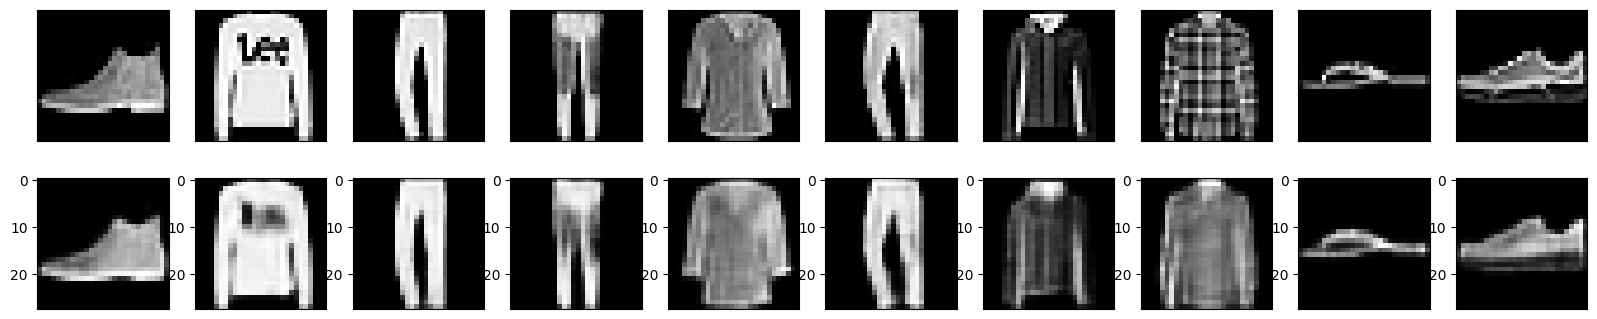

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(fashion_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fashion_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
#     ax.get_y


In [7]:
fashion_train.shape, fashion_train_labels.shape

((60000, 28, 28, 1), (60000,))

In [8]:
# Создание модели для Fashion MNIST на основе весов кодировщика
encoder = Model(input_img, encoded)
for layer in encoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(fashion_train, fashion_train_labels, epochs=20, batch_size=256, validation_data=(fashion_test, fashion_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test)


Epoch 1/20
235/235 [==============================] - 16s 63ms/step - loss: 0.7525 - accuracy: 0.7539 - val_loss: 0.5482 - val_accuracy: 0.8006
Epoch 2/20
235/235 [==============================] - 14s 61ms/step - loss: 0.4843 - accuracy: 0.8278 - val_loss: 0.4790 - val_accuracy: 0.8303
Epoch 3/20
235/235 [==============================] - 15s 62ms/step - loss: 0.4379 - accuracy: 0.8443 - val_loss: 0.4492 - val_accuracy: 0.8377
Epoch 4/20
235/235 [==============================] - 15s 63ms/step - loss: 0.4121 - accuracy: 0.8536 - val_loss: 0.4249 - val_accuracy: 0.8491
Epoch 5/20
235/235 [==============================] - 15s 63ms/step - loss: 0.3950 - accuracy: 0.8598 - val_loss: 0.4133 - val_accuracy: 0.8541
Epoch 6/20
235/235 [==============================] - 14s 61ms/step - loss: 0.3823 - accuracy: 0.8645 - val_loss: 0.4038 - val_accuracy: 0.8583
Epoch 7/20
235/235 [==============================] - 15s 63ms/step - loss: 0.3732 - accuracy: 0.8675 - val_loss: 0.3980 - val_accuracy:

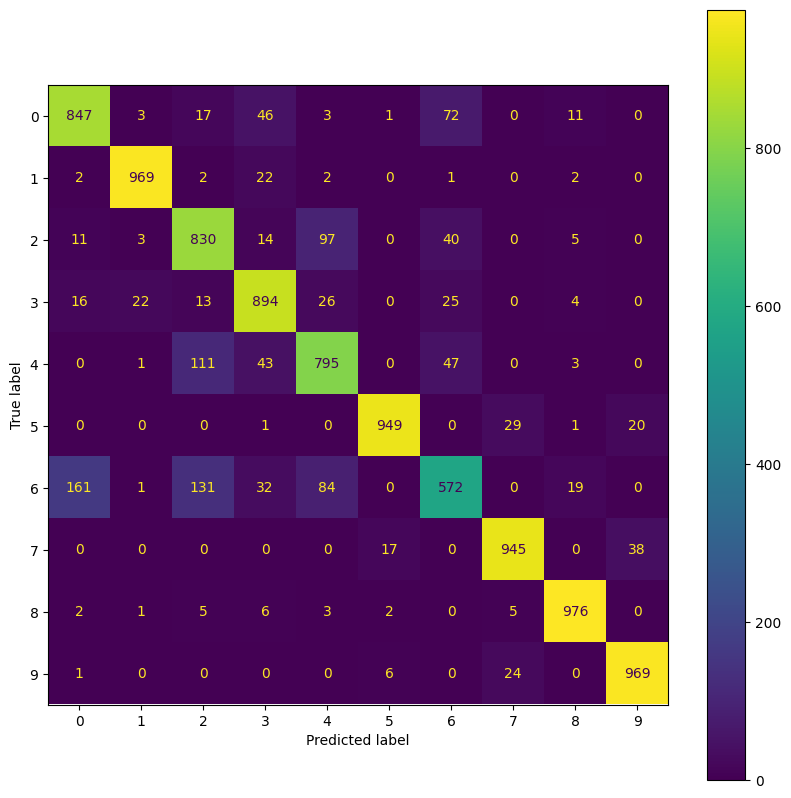

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(ax=ax)  # Измените метки классов, если у вас другие
plt.show()


In [ ]:
(fashion_train, fashion_train_labels), (fashion_test, fashion_test_labels) = tf.keras.datasets.fashion_mnist.load_data()
(mnist_train, mnist_train_labels), (mnist_test, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
fashion_train = fashion_train.astype('float32') / 255.
fashion_test = fashion_test.astype('float32') / 255.

mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # Fashion MNIST - черно-белые изображения

# Энкодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что fashion_train и fashion_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
fashion_train = fashion_train.reshape(-1, 28, 28, 1)
fashion_test = fashion_test.reshape(-1, 28, 28, 1)

autoencoder.fit(fashion_train, fashion_train,
                epochs=20,
                batch_size=256,
                validation_data=(fashion_test, fashion_test))


In [1]:
encoder = Model(input_img, encoded)
for layer in encoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(mnist_train, mnist_train_labels, epochs=20, batch_size=256, validation_data=(mnist_test, mnist_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test)

NameError: name 'Model' is not defined

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [11]:
!pip install opencv-python


     |████████████████████████████████| 61.7 MB 6.4 MB/s eta 0:00:01


In [12]:
from keras.layers import Input, UpSampling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense
from keras.datasets import fashion_mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Преобразование изображений в трехканальные
train_images = np.stack([train_images]*3, axis=-1)
test_images = np.stack([test_images]*3, axis=-1)

# Нормализация данных
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Установите размер ввода изображения
input_tensor = Input(shape=(28, 28, 3))

# Используйте UpSampling2D для увеличения размера изображения до 224x224
x = UpSampling2D(size=(8, 8))(input_tensor)  # 28*8 = 224

# Включите VGG16 в вашу модель
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)

# Добавьте новые верхние слои
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)

# Заморозьте слои базовой модели VGG16
for layer in base_model.layers:
    layer.trainable = False

model.summary()



58889256/58889256 [==============================] - 12s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     7385

In [13]:
# Обучение модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=32, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 4924s 3s/step - loss: 0.6354 - accuracy: 0.7755 - val_loss: 0.5323 - val_accuracy: 0.8036
Epoch 2/5
1875/1875 [==============================] - 4848s 3s/step - loss: 0.4319 - accuracy: 0.8450 - val_loss: 0.4314 - val_accuracy: 0.8452
Epoch 3/5
1875/1875 [==============================] - 5960s 3s/step - loss: 0.3901 - accuracy: 0.8595 - val_loss: 0.4565 - val_accuracy: 0.8305
Epoch 4/5
1875/1875 [==============================] - 4535s 2s/step - loss: 0.3656 - accuracy: 0.8672 - val_loss: 0.3573 - val_accuracy: 0.8697
Epoch 5/5
1875/1875 [==============================] - 5148s 3s/step - loss: 0.3473 - accuracy: 0.8734 - val_loss: 0.3689 - val_accuracy: 0.8672
